#### Splitting and Chunking

In [2]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [3]:
def load_docs():
    '''load documents from pdf files'''
    pdf_files_path = ''
    urls = [
            "Prompt Engineering | Lil'Log.pdf",
        ]

    docs = [PyPDFLoader(pdf_files_path+url).load_and_split() for url in urls]
    docs_list = [item for sublist in docs for item in sublist]
    
    print(f"Loaded {len(docs_list)} documents")
    return docs_list

In [5]:
docs = load_docs()

#create text splitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=600, chunk_overlap=0)
#split documents
doc_splits = text_splitter.split_documents(docs) 

Ignoring wrong pointing object 56 0 (offset 0)
Ignoring wrong pointing object 58 0 (offset 0)
Ignoring wrong pointing object 60 0 (offset 0)
Ignoring wrong pointing object 101 0 (offset 0)
Ignoring wrong pointing object 260 0 (offset 0)
Ignoring wrong pointing object 276 0 (offset 0)


Loaded 19 documents


#### LLM 

In [6]:
# provide the api keys
ANTHROPIC_API_KEY=''
OPENAI_API_KEY = ''

In [7]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

async def generate(llm, prompt, prompt_vals, struct=None, isStructuredResponse=False):
    input_vars = [key for key in prompt_vals.keys()]
    prompt = PromptTemplate(template=prompt, input_variables=input_vars)

    # Chain
    if isStructuredResponse:
        structured_llm = llm.with_structured_output(struct, method='json_schema')
        chain = prompt | structured_llm 
    else:
        chain = prompt | llm | StrOutputParser()
    
    # Run
    generation = await chain.ainvoke(prompt_vals)
    
    return generation

In [8]:
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI

llm = ChatAnthropic(model='claude-3-haiku-20240307', anthropic_api_key=ANTHROPIC_API_KEY, max_tokens_to_sample=4096)
# llm = ChatAnthropic(model='claude-3-5-sonnet-20240620', anthropic_api_key=ANTHROPIC_API_KEY)
# llm = ChatOpenAI(model='gpt-4o-2024-08-06', openai_api_key=OPENAI_API_KEY)

#### Domains and Personas

In [9]:
GENERATE_DOMAIN_PROMPT = """
You are an intelligent assistant that helps a human to analyze the information in a text document.
Given a sample text, help the user by assigning a descriptive domain that summarizes what the text is about.

Text: {input_text}
YOU MUST ONLY RETURN THE DOMAIN NAME AS A STRING WITH NO ADDITIONAL INFORMATION.
"""

# GENERATE_PERSONA_PROMPT = """
# You are an intelligent assistant that helps a human to analyze the information in a text document.
# Given a specific type of task and sample text, help the user by generating a 3 to 4 sentence description of an expert who could help solve the problem.
# Use a format similar to the following:
# You are an expert {{role}}. You are skilled at {{relevant skills}}. You are adept at helping people with {{specific task}}.

# task: {sample_task}
# YOU MUST ONLY RETURN THE PERSONA DESCRIPTION AS A STRING WITH NO ADDITIONAL INFORMATION.
# """

DEFAULT_TASK = """
Identify the relations and structure of the community of interest, specifically within the {domain} domain.
"""

In [10]:
# Generate domain
docs_text = " ".join([doc.page_content for doc in doc_splits])
domain = await generate(llm, GENERATE_DOMAIN_PROMPT, {'input_text': docs_text})
print(f"Domain: {domain}")

# # Generate persona
# persona = generate(llm, GENERATE_PERSONA_PROMPT, {'sample_task': DEFAULT_TASK.format(domain=domain)})
# print(f"Persona: {persona}")

Domain: Prompt Engineering


#### Entity Types Extraction

In [11]:
ENTITY_TYPE_GENERATION_JSON_PROMPT = """
The goal is to study the connections and relations between the entity types and their features in order to understand all available information from the text.
The user's task is to {task}.
As part of the analysis, you want to identify the entity types present in the following text.
The entity types must be relevant to the user task.
The entity types must be concise, comprehensive and cover all the relevant information in the text.
Avoid general entity types such as "other" or "unknown".
This is VERY IMPORTANT: Do not generate redundant or overlapping entity types. For example, if the text contains "company" and "organization" entity types, you should return only one of them.
Don't worry about quantity, always choose quality over quantity. And make sure EVERYTHING in your answer is relevant to the context of entity extraction.
=====================================================================

EXAMPLE SECTION: The following section includes example output. These examples **must be excluded from your answer**.
EXAMPLE 
Task: Identify the full range of basic forces, factors, and trends that would indirectly shape an issue.
Text: Industry leaders such as Panasonic are vying for supremacy in the battery production sector. They are investing heavily in research and development and are exploring new technologies to gain a competitive edge.
JSON RESPONSE:
{{"entity_types": [organization, technology, sectors, investment strategies] }}
END OF EXAMPLE 

=====================================================================
REAL DATA: The following section is the real data. You should use only this real data to prepare your answer. Generate Entity Types only.
Task: {task}
Text: {input_text}
JSON response:
{{"entity_types": [<entity_types>] }}

YOU MUST ONLY RETURN THE ENTITY TYPES AS A JSON RESPONSE WITH NO ADDITIONAL INFORMATION.
"""


ENTITY_TYPE_GENERATION_CONTINUATION_JSON_PROMPT = """
The goal is to identify the entity types that were missed during extraction in the following text.
The entity types must be relevant to the user task.
The entity types must be concise, comprehensive and cover all the relevant information in the text.
Avoid general entity types such as "other" or "unknown".
This is VERY IMPORTANT: Do not generate redundant or overlapping entity types. For example, if the text contains "company" and "organization" entity types, you should return only one of them.
Don't worry about quantity, always choose quality over quantity. And make sure EVERYTHING in your answer is relevant to the context of entity extraction.
=====================================================================

EXAMPLE SECTION: The following section includes example output. These examples **must be excluded from your answer**.
EXAMPLE 
Text: Industry leaders such as Panasonic are vying for supremacy in the battery production sector. They are investing heavily in research and development and are exploring new technologies to gain a competitive edge.
Already extracted entity types: [organization, technology, sectors, investment strategies]
JSON RESPONSE:
{{"entity_types": [organization, technology, sectors, investment strategies, battery production] }}
END OF EXAMPLE 

REAL DATA: The following section is the real data. You should use only this real data to prepare your answer. Generate Entity Types only.
Text: {input_text}
Already extracted entity types: {entity_types}
JSON response:
{{"entity_types": [<entity_types>] }}

YOU MUST APPEND THE NEW ENTITY TYPES TO THE ALREADY EXTRACTED ENTITY TYPES AND RETURN THE ENTITY TYPES AS A JSON RESPONSE WITH NO ADDITIONAL INFORMATION.
"""

In [12]:
from typing import List
from typing_extensions import TypedDict
from langchain_core.pydantic_v1 import BaseModel, Field

class EntityTypes(BaseModel):
    types: List[str] = Field(..., description="List of entity types extracted from the text")

class EntityTypes(TypedDict):
    entity_types: List[str] = Field(..., description="List of entity types extracted from the text")


doc_text = " ".join([doc.page_content for doc in doc_splits])
entity_types = await generate(llm, ENTITY_TYPE_GENERATION_JSON_PROMPT, {'task': DEFAULT_TASK.format(domain=domain), 'input_text': doc_text}, struct=None, isStructuredResponse=False)
entity_types

'{\n  "entity_types": [\n    "language model",\n    "prompt",\n    "reasoning",\n    "instruction",\n    "example",\n    "task",\n    "sentiment",\n    "retrieval",\n    "api",\n    "programming",\n    "method",\n    "technique",\n    "model architecture"\n  ]\n}'

In [13]:
doc_text = " ".join([doc.page_content for doc in doc_splits])
entity_types = await generate(llm, ENTITY_TYPE_GENERATION_CONTINUATION_JSON_PROMPT, {'task': DEFAULT_TASK.format(domain=domain), 'input_text': doc_text, 'entity_types': entity_types}, struct=None, isStructuredResponse=False)
entity_types

'{\n  "entity_types": [\n    "language model",\n    "prompt",\n    "reasoning",\n    "instruction",\n    "example",\n    "task",\n    "sentiment",\n    "retrieval",\n    "api",\n    "programming",\n    "method",\n    "technique",\n    "model architecture",\n    "dataset",\n    "bias",\n    "probability",\n    "embedding",\n    "search",\n    "reinforcement learning",\n    "generation",\n    "cluster",\n    "question",\n    "answer"\n  ]\n}'

#### Entities and Relationships Extraction

In [14]:
ENTITY_RELATIONSHIPS_GENERATION_JSON_PROMPT = """
-Goal-
Given a text document that is potentially relevant to this activity and a list of entity types, identify all entities of those types from the text and all relationships among the identified entities.

-Steps-
1. Identify all entities. For each identified entity, extract the following information:
- entity_name: Name of the entity
- entity_type: One of the following types: [{entity_types}]
- entity_description: Comprehensive description of the entity's attributes and activities

Format each entity output as a JSON entry with the following format:
{{"name": <entity name>, "type": <type>, "description": <entity description>}}

2. From the entities identified in step 1, identify all pairs of (source_entity, target_entity) that are *clearly related* to each other.
For each pair of related entities, extract the following information:
- source_entity: name of the source entity, as identified in step 1
- target_entity: name of the target entity, as identified in step 1
- relationship_description: explanation as to why you think the source entity and the target entity are related to each other
- relationship_strength: an integer score between 1 to 10, indicating strength of the relationship between the source entity and target entity

3. source_entity and target_entity must belong to the list of entities identified in step 1.

4. Note that these relationships and entities will be used to create a knowledge graph.

5. The created entities and relationships should provide a comprehensive understanding once analyzed within the knowledge graph.

6. Name of entities **MUST BE SMALL CASED**

Format each relationship as a JSON entry with the following format:

{{"source": <source_entity>, "target": <target_entity>, "relationship": <relationship_description>, "relationship_strength": <relationship_strength>}}

-Real Data-
######################
text: {input_text}
######################
YOU MUST ONLY RETURN THE ENTITIES AND RELATIONSHIPS AS A JSON RESPONSE WITH NO ADDITIONAL INFORMATION.
"""



In [15]:
entity_types = entity_types.replace("```json\n", "").replace("```", "")

In [16]:
import json
entity_types = json.loads(entity_types)
print(entity_types)

{'entity_types': ['language model', 'prompt', 'reasoning', 'instruction', 'example', 'task', 'sentiment', 'retrieval', 'api', 'programming', 'method', 'technique', 'model architecture', 'dataset', 'bias', 'probability', 'embedding', 'search', 'reinforcement learning', 'generation', 'cluster', 'question', 'answer']}


In [17]:
import json
import re

def extract_json_data(text):
    # Extract entities
    entities_match = re.search(r'"entities": \[(.*?)\]', text, re.DOTALL)
    entities_text = entities_match.group(1) if entities_match else ''
    entities = re.findall(r'\{(.*?)\}', entities_text, re.DOTALL)
    
    parsed_entities = []
    for entity in entities:
        entity_dict = {}
        for line in entity.split('\n'):
            if ':' in line:
                key, value = line.split(':', 1)
                key = key.strip().strip('"')
                value = value.strip().strip(',').strip('"')
                entity_dict[key] = value
        parsed_entities.append(entity_dict)

    # Extract relationships
    relationships_match = re.search(r'"relationships": \[(.*?)(?:\]|$)', text, re.DOTALL)
    relationships_text = relationships_match.group(1) if relationships_match else ''
    relationships = re.findall(r'\{(.*?)\}', relationships_text, re.DOTALL)
    
    parsed_relationships = []
    for relationship in relationships:
        relationship_dict = {}
        for line in relationship.split('\n'):
            if ':' in line:
                key, value = line.split(':', 1)
                key = key.strip().strip('"')
                value = value.strip().strip(',').strip('"')
                if key == "relationship_strength":
                    value = int(value)
                relationship_dict[key] = value
        parsed_relationships.append(relationship_dict)

    # Combine entities and relationships
    result = {
        "entities": parsed_entities,
        "relationships": parsed_relationships
    }

    return json.dumps(result, indent=2)


In [18]:
import asyncio

MAX_EXAMPLES = 20

entities_and_relationships = []
entiy_names = []

#can be used for langchain structured response
class Entity(BaseModel):
    name: str = Field(..., description="Name of the entity")
    type: str = Field(..., description="Type of the entity")
    description: str = Field(..., description="Description of the entity's attributes and activities")
    
class Relationship(BaseModel):
    source: str = Field(..., description="Name of the source entity")
    target: str = Field(..., description="Name of the target entity")
    relationship: str = Field(..., description="Explanation as to why the source entity and the target entity are related to each other")
    relationship_strength: int = Field(..., description="An integer score between 1 to 10, indicating strength of the relationship between the source entity and target entity")

class EntityRelationships(BaseModel):
    entities: List[Entity] = Field(..., description="List of entities extracted from the text")
    relationships: List[Relationship] = Field(..., description="List of relationships among the identified entities")

     
tasks = [generate(llm, ENTITY_RELATIONSHIPS_GENERATION_JSON_PROMPT, {'entity_types': entity_types, 'input_text': doc.page_content}, EntityRelationships, isStructuredResponse=False) for doc in doc_splits[:MAX_EXAMPLES]]

for task in asyncio.as_completed(tasks):
    eAndr = await task
    print(eAndr)
    entities_and_relationships.append(eAndr)


{
  "entities": [
    {
      "name": "self-ask",
      "type": "method",
      "description": "A method that works with external search queries to solve problems."
    },
    {
      "name": "tree of thoughts",
      "type": "method",
      "description": "An extension of the Chain of Thought (CoT) method that explores multiple reasoning possibilities at each step, creating a tree structure."
    },
    {
      "name": "chain of thought",
      "type": "method",
      "description": "A method that decomposes the problem into multiple thought steps and generates multiple thoughts per step."
    },
    {
      "name": "breadth-first search",
      "type": "method",
      "description": "A search algorithm that explores all the neighboring nodes at the present depth before moving on to the nodes at the next depth level."
    },
    {
      "name": "depth-first search",
      "type": "method",
      "description": "A search algorithm that goes deeper into the graph before exploring other 

In [19]:
#parse json data
parsed_entities_and_relationships = []
for eAndr in entities_and_relationships:
    print(extract_json_data(eAndr))
    parsed_entities_and_relationships.append(extract_json_data(eAndr))


{
  "entities": [
    {
      "name": "self-ask",
      "type": "method",
      "description": "A method that works with external search queries to solve problems."
    },
    {
      "name": "tree of thoughts",
      "type": "method",
      "description": "An extension of the Chain of Thought (CoT) method that explores multiple reasoning possibilities at each step, creating a tree structure."
    },
    {
      "name": "chain of thought",
      "type": "method",
      "description": "A method that decomposes the problem into multiple thought steps and generates multiple thoughts per step."
    },
    {
      "name": "breadth-first search",
      "type": "method",
      "description": "A search algorithm that explores all the neighboring nodes at the present depth before moving on to the nodes at the next depth level."
    },
    {
      "name": "depth-first search",
      "type": "method",
      "description": "A search algorithm that goes deeper into the graph before exploring other 

#### Knowledge Graph

In [20]:
import networkx as nx

graph = nx.Graph()

for eAndr in parsed_entities_and_relationships:
    eAndr = json.loads(eAndr)
    for entity in eAndr['entities']:
        print(entity)
        graph.add_node(entity['name'], type=entity['type'], description=entity['description'])

    for relationship in eAndr['relationships']:
        graph.add_edge(relationship['source'], relationship['target'], relationship=relationship['relationship'], strength=relationship['relationship_strength'])

{'name': 'self-ask', 'type': 'method', 'description': 'A method that works with external search queries to solve problems.'}
{'name': 'tree of thoughts', 'type': 'method', 'description': 'An extension of the Chain of Thought (CoT) method that explores multiple reasoning possibilities at each step, creating a tree structure.'}
{'name': 'chain of thought', 'type': 'method', 'description': 'A method that decomposes the problem into multiple thought steps and generates multiple thoughts per step.'}
{'name': 'breadth-first search', 'type': 'method', 'description': 'A search algorithm that explores all the neighboring nodes at the present depth before moving on to the nodes at the next depth level.'}
{'name': 'depth-first search', 'type': 'method', 'description': 'A search algorithm that goes deeper into the graph before exploring other areas.'}
{'name': 'classifier', 'type': 'method', 'description': 'A method used to evaluate each state in the Tree of Thoughts method, via a prompt or majori

In [21]:
str(graph)

'Graph with 160 nodes and 161 edges'

Text(0.5, 1.0, 'Knowledge Graph')

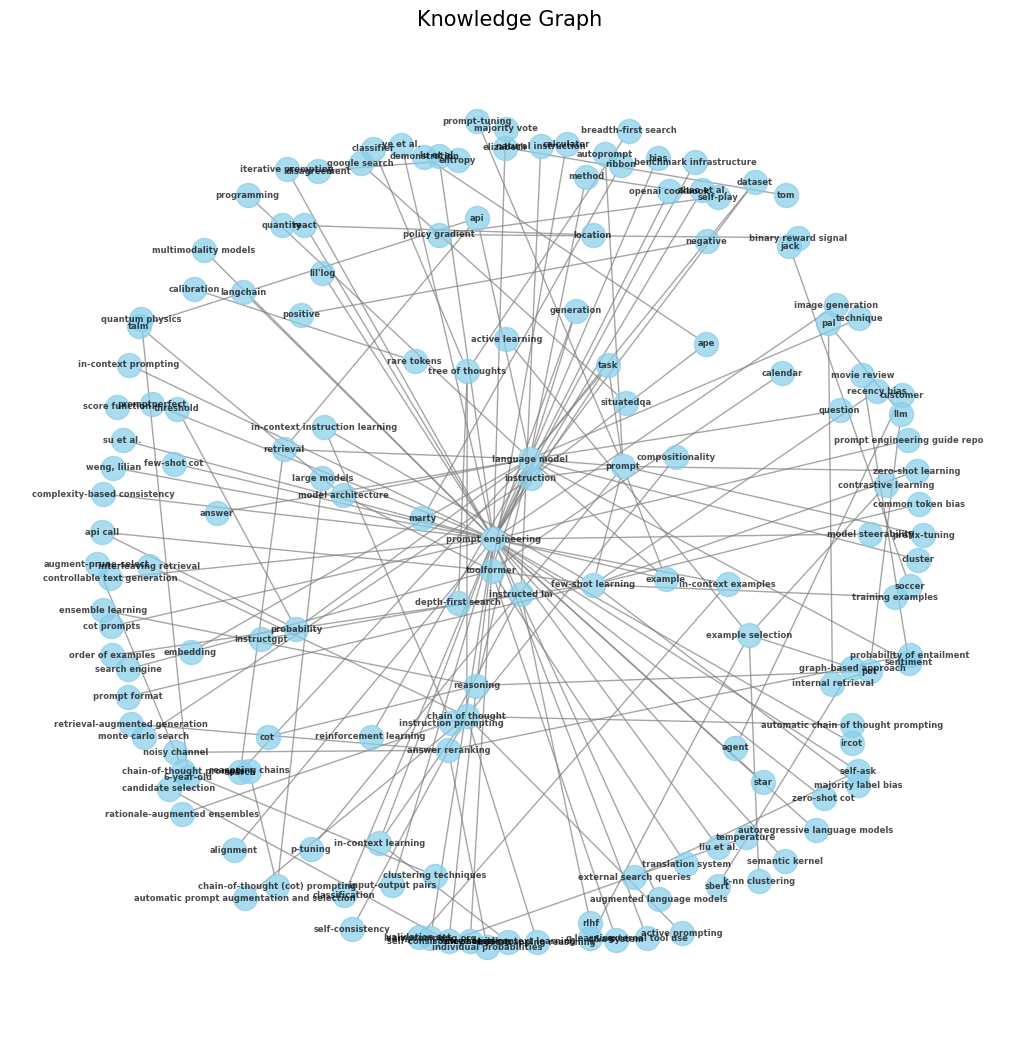

In [24]:
# visualizing the graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(graph, k=0.7)

# show node names
for node in graph.nodes():
    graph.nodes[node]['label'] = node

nx.draw(graph, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=6,
            font_weight='bold', font_color='black', edge_color='gray', linewidths=1, alpha=0.7, arrows=True)

#add title
plt.title("Knowledge Graph", fontsize=15)


#### Detecting Communities

In [23]:
from graspologic.partition import hierarchical_leiden

max_cluster_size = 100
seed = 42

community_mapping = hierarchical_leiden(
    graph, max_cluster_size=max_cluster_size, random_seed=seed
)

results: dict[int, dict[str, int]] = {}
for partition in community_mapping:
    results[partition.level] = results.get(partition.level, {})
    results[partition.level][partition.node] = partition.cluster
    
print(results)

{0: {'self-ask': 0, 'external search queries': 0, 'prompt engineering': 0, 'openai cookbook': 0, 'langchain': 0, 'prompt engineering guide repo': 0, 'learnprompting.org': 0, 'promptperfect': 0, 'semantic kernel': 0, 'zhao et al.': 0, 'liu et al.': 0, 'lu et al.': 0, 'ye et al.': 0, 'su et al.': 0, 'weng, lilian': 0, 'classification': 0, "lil'log": 0, 'few-shot cot': 0, 'zero-shot cot': 0, 'majority vote': 0, 'star': 0, 'complexity-based consistency': 0, 'cot prompts': 0, 'ircot': 0, 'react': 0, 'in-context examples': 0, 'input-output pairs': 0, 'augmented language models': 0, 'in-context prompting': 0, 'autoregressive language models': 0, 'cloze tests': 0, 'image generation': 0, 'multimodality models': 0, 'alignment': 0, 'model steerability': 0, 'controllable text generation': 0, 'benchmark infrastructure': 0, 'iterative prompting': 0, 'external tool use': 0, 'validation set': 0, 'tree of thoughts': 1, 'chain of thought': 1, 'breadth-first search': 1, 'depth-first search': 1, 'classifi

/usr/local/lib/python3.11/site-packages/graspologic/partition/leiden.py:607: UserWarning: Leiden partitions do not contain all nodes from the input graph because input graph contained isolate nodes.
  warnings.warn(


In [25]:
print("Number of communities: ", len(set([partition.cluster for partition in community_mapping])))


Number of communities:  22


In [26]:
results

{0: {'self-ask': 0,
  'external search queries': 0,
  'prompt engineering': 0,
  'openai cookbook': 0,
  'langchain': 0,
  'prompt engineering guide repo': 0,
  'learnprompting.org': 0,
  'promptperfect': 0,
  'semantic kernel': 0,
  'zhao et al.': 0,
  'liu et al.': 0,
  'lu et al.': 0,
  'ye et al.': 0,
  'su et al.': 0,
  'weng, lilian': 0,
  'classification': 0,
  "lil'log": 0,
  'few-shot cot': 0,
  'zero-shot cot': 0,
  'majority vote': 0,
  'star': 0,
  'complexity-based consistency': 0,
  'cot prompts': 0,
  'ircot': 0,
  'react': 0,
  'in-context examples': 0,
  'input-output pairs': 0,
  'augmented language models': 0,
  'in-context prompting': 0,
  'autoregressive language models': 0,
  'cloze tests': 0,
  'image generation': 0,
  'multimodality models': 0,
  'alignment': 0,
  'model steerability': 0,
  'controllable text generation': 0,
  'benchmark infrastructure': 0,
  'iterative prompting': 0,
  'external tool use': 0,
  'validation set': 0,
  'tree of thoughts': 1,
  'c

#### Summarization

In [27]:
SUMMARIZE_PROMPT = """
As an AI assistant, your task is to synthesize the provided data into a coherent and concise summary. The data consists of entities with their descriptions and relationships between them.

Your objective:
1. Analyze the given information thoroughly.
2. Create a clear, concise, and informative summary that captures the essence of the data.
3. Present the information in a logical and easily understandable manner.
4. Ensure the summary flows naturally and reads like a brief, cohesive explanation.

Guidelines:
- Do not directly restate or list the provided descriptions or relationships.
- Integrate the information to form a comprehensive overview.
- Focus on key points and meaningful connections between entities.
- Avoid introducing any information not present in the given data.
- Use simple, accessible language to enhance clarity.

Input Data:
Entities and their descriptions: {entity_list}
Relationships: {relationship_list}

Your task is to provide a concise summary based on this data. DO NOT ADD ANY ADDITIONAL INFORMATION.
"""

In [28]:
traversed_relationships = list(nx.bfs_edges(graph, source='prompt', depth_limit=2))
traversed_relationships = [(edge[0], edge[1], graph.get_edge_data(edge[0], edge[1])) for edge in traversed_relationships]
traversed_relationships

[('prompt',
  'language model',
  {'relationship': 'Prompts are used to guide and instruct language models to perform specific tasks.',
   'strength': 9}),
 ('prompt',
  'instruction',
  {'relationship': 'Prompts are a form of instruction that guide language models to perform specific tasks.',
   'strength': 8}),
 ('prompt',
  'example',
  {'relationship': 'Prompts can include examples to help language models understand the desired task or output.',
   'strength': 7}),
 ('prompt',
  'task',
  {'relationship': 'Prompts are used to specify the task that a language model should perform.',
   'strength': 9}),
 ('prompt',
  'autoprompt',
  {'relationship': 'autoprompt is a method to automatically design prompts',
   'strength': 9}),
 ('prompt',
  'prefix-tuning',
  {'relationship': 'prefix-tuning is a method to automatically design prompts',
   'strength': 8}),
 ('prompt',
  'p-tuning',
  {'relationship': 'p-tuning is a method to automatically design prompts',
   'strength': 8}),
 ('prompt'

In [29]:
entities = set()
for edge in traversed_relationships:
    entities.add((edge[0], graph.nodes[edge[0]].get('description')))
    entities.add((edge[1], graph.nodes[edge[1]].get('description')))

relationship_list = []
for edge in traversed_relationships:
    relationship_list.append((edge[0], edge[1], edge[2]['relationship']))
    
summary = await generate(llm, SUMMARIZE_PROMPT, {'entity_list': list(entities), 'relationship_list': relationship_list})
print(summary)


The provided data presents an overview of various concepts and techniques related to language models and prompt engineering. Language models are machine learning models that can generate human-like text by learning patterns from large text datasets. Prompts are used to guide and instruct language models to perform specific tasks, such as answering questions, generating text, or performing reasoning. 

Prompt engineering is a crucial technique for designing and refining prompts to ensure language models produce desired outputs. Different methods, such as autoprompt, prefix-tuning, p-tuning, and prompt-tuning, have been developed to automatically design effective prompts by treating them as trainable parameters.

The data also highlights the importance of few-shot learning, where language models are trained on a small set of examples. The choice of prompt format, training examples, and the order of examples can significantly impact the performance of few-shot learning, leading to dramati

#### Querying

In [30]:
QUERY_ENTITIES_PROMPT = """
As an AI assistant, your task is to reply to a user query based on a knowledge graph. 

Your objective in this task is as follows:
1. Analyze the given query.
2. You will be given the entity names and the number of relationships connected to each entity.
3. Decide which entities are most relevant to the query.

Input Data:
Query: "{query}"
Entities and their descriptions: {entity_list}
Entities and their number of relationships: {relationship_count}

Output:
Format the output as a json with the following structure:
{{"relevant_entities": [<relevant_entities>]}}

YOU MUST ONLY RETURN THE MOST RELEVANT ENTITY NAMES AS A LIST WITH NO ADDITIONAL INFORMATION.
"""

In [31]:
entities = list(graph.nodes(data=True))

In [36]:
entities

[('self-ask',
  {'type': 'method',
   'description': 'A method where the model is prompted to iteratively ask follow-up questions to construct a thought process, with answers obtained from search engine results.',
   'label': 'self-ask'}),
 ('tree of thoughts',
  {'type': 'method',
   'description': 'An extension of the Chain of Thought (CoT) method that explores multiple reasoning possibilities at each step, creating a tree structure.',
   'label': 'tree of thoughts'}),
 ('chain of thought',
  {'type': 'reasoning',
   'description': 'A prompting technique where language models are encouraged to provide step-by-step reasoning to arrive at the final answer.',
   'label': 'chain of thought'}),
 ('breadth-first search',
  {'type': 'method',
   'description': 'A search algorithm that explores all the neighboring nodes at the present depth before moving on to the nodes at the next depth level.',
   'label': 'breadth-first search'}),
 ('depth-first search',
  {'type': 'method',
   'descripti

In [37]:
entity_list = list(entities)
relationship_count = {entity: len(list(graph.neighbors(entity))) for entity, _ in entity_list}

query = 'How tools can be used while prompting a language model?'

relevant_entities = await generate(llm, QUERY_ENTITIES_PROMPT, {'query': query, 'entity_list': entity_list, 'relationship_count': relationship_count})
print(relevant_entities)

{
    "relevant_entities": [
        "language model",
        "prompt engineering",
        "chain of thought",
        "toolformer",
        "self-play",
        "api call"
    ]
}


In [38]:
relevant_entities = json.loads(relevant_entities)
relevant_entities

{'relevant_entities': ['language model',
  'prompt engineering',
  'chain of thought',
  'toolformer',
  'self-play',
  'api call']}

In [39]:
QUERY_PROMPT = """
As an AI assistant, your task is to answer a user query based on a knowledge graph.

Your objective in this task is as follows:
1. Analyze the given query.
2. You will be given the involved entities and the relationships between them.
3. Provide a concise, detailed and informative response to the query.

Input Data:
Query: "{query}"
Entities and their descriptions: {entity_list}
Relationships: {relationship_list}

YOU MUST ONLY RETURN THE RESPONSE TO THE QUERY AS A STRING WITH NO ADDITIONAL INFORMATION.
"""

In [40]:
relevant_entities_list = [entity for entity in relevant_entities['relevant_entities']]

relevant_relationships_list = []
for entity in relevant_entities_list:
    neighbors = list(graph.neighbors(entity))
    for neighbor in neighbors:
        relevant_relationships_list.append((entity, neighbor, graph.get_edge_data(entity, neighbor)))

relevant_entities_list = [(entity, graph.nodes[entity].get('description')) for entity in relevant_entities_list]

response = await generate(llm, QUERY_PROMPT, {'query': query, 'entity_list': relevant_entities_list, 'relationship_list': relevant_relationships_list})
print(response)

The key ways that tools can be used while prompting a language model are:

1. Prompt engineering: Designing effective prompts to guide the language model's text generation and reasoning process, such as using chain-of-thought prompts.

2. Incorporating tool APIs: Language models like Toolformer are trained to directly interact with external tools (e.g., calculator, search engine, translation system) during the text generation process, allowing them to leverage the capabilities of these tools.

3. Self-play training: The self-play approach used by models like Toolformer involves the language model interacting with tool APIs to iteratively expand the dataset and improve its performance on tasks that require tool usage.

4. Multi-step reasoning: Tools can be used to support the language model's step-by-step reasoning process, as in the chain-of-thought prompting technique, where the model is encouraged to provide detailed logical steps to arrive at the final answer.
